In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE
import os

In [2]:
path = '../0.data_final_12/'
image_folder = f'{path}data-filter'
image_path = f'{image_folder}/01d6ce0d-6bff-4a49-86ec-26b39b763961.png'

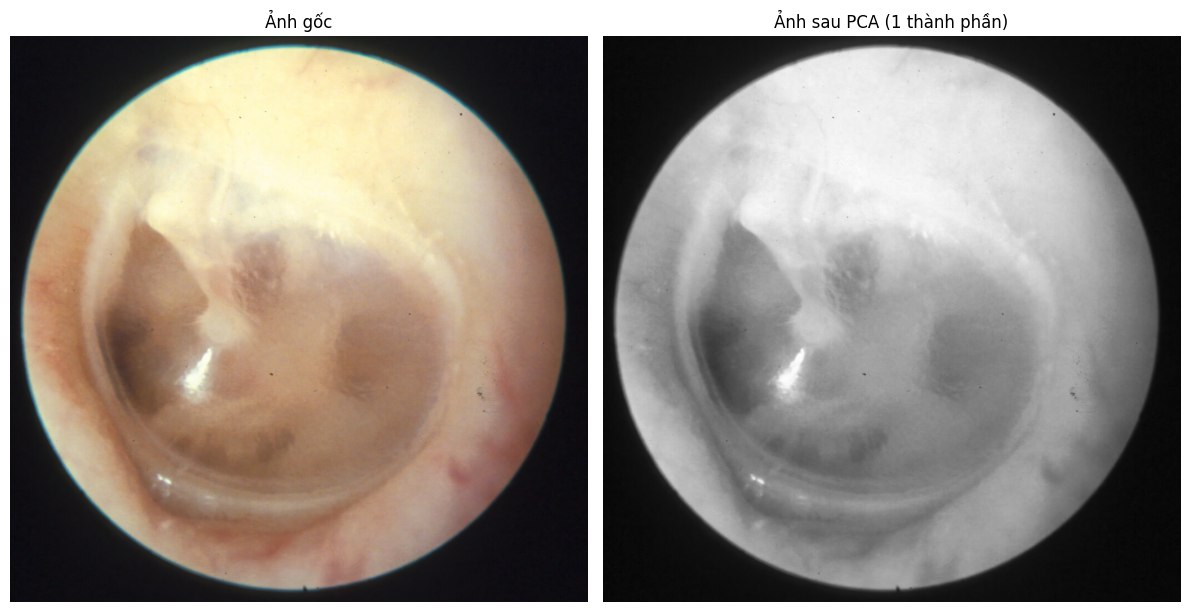

In [3]:
# Đọc ảnh
image = cv2.imread(image_path)
image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# Lấy kích thước ảnh
h, w, c = image_rgb.shape

# Chuyển ảnh về dạng 2D (pixel x channels)
pixels = image_rgb.reshape(-1, 3)

# Áp dụng PCA để giảm từ 3 kênh màu -> 1 thành phần chính (giống như grayscale nâng cao)
pca = PCA(n_components=1)
pixels_pca = pca.fit_transform(pixels)

# Chuẩn hóa lại để ảnh có giá trị trong khoảng [0, 255]
pixels_pca_norm = (pixels_pca - pixels_pca.min()) / (pixels_pca.max() - pixels_pca.min())
pixels_pca_uint8 = (pixels_pca_norm * 255).astype(np.uint8)

# Chuyển lại về dạng ảnh 2D
image_pca = pixels_pca_uint8.reshape(h, w)

# Hiển thị ảnh gốc và ảnh sau PCA
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.imshow(image_rgb)
plt.title("Ảnh gốc")
plt.axis("off")

plt.subplot(1, 2, 2)
plt.imshow(image_pca, cmap='gray')
plt.title("Ảnh sau PCA (1 thành phần)")
plt.axis("off")

plt.tight_layout()
plt.show()

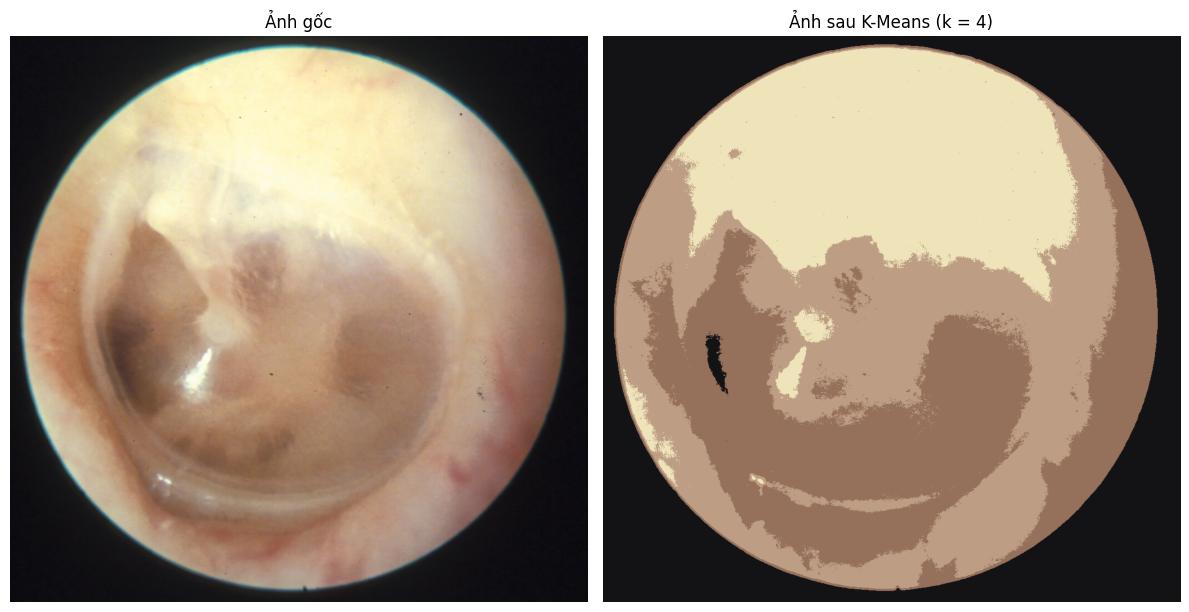

In [4]:
# Đọc và chuyển đổi ảnh sang RGB
image = cv2.imread(image_path)
image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# Lấy kích thước ảnh
h, w, c = image_rgb.shape

# Chuyển ảnh sang mảng 2D (n_pixel x 3)
pixels = image_rgb.reshape(-1, 3)

# Áp dụng K-Means clustering
k = 4  # số lượng cụm
kmeans = KMeans(n_clusters=k, random_state=42)
labels = kmeans.fit_predict(pixels)
clustered_pixels = kmeans.cluster_centers_.astype(np.uint8)[labels]

# Chuyển lại ảnh đã phân cụm
clustered_image = clustered_pixels.reshape(h, w, 3)

# Hiển thị ảnh gốc và ảnh sau clustering
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.imshow(image_rgb)
plt.title("Ảnh gốc")
plt.axis("off")

plt.subplot(1, 2, 2)
plt.imshow(clustered_image)
plt.title(f"Ảnh sau K-Means (k = {k})")
plt.axis("off")

plt.tight_layout()
plt.show()


In [5]:
def cluster_and_visualize_image(image_path, resize_dim=(128, 128), k=4):
    # --- Bước 1: Đọc ảnh ---
    image = cv2.imread(image_path)
    if image is None:
        raise ValueError(f"Không thể đọc ảnh: {image_path}")
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image_rgb = cv2.resize(image_rgb, resize_dim)
    h, w, _ = image_rgb.shape

    pixels = image_rgb.reshape(-1, 3)

    # --- Bước 2: PCA ---
    pca = PCA(n_components=2)
    pixels_pca = pca.fit_transform(pixels)

    # Tạo ảnh từ PCA 2D: dùng 2 thành phần PCA làm R và G, B = 0
    pca_img = np.zeros((pixels_pca.shape[0], 3))
    pca_img[:, 0:2] = pixels_pca  # R,G
    # Chuẩn hóa về [0, 255]
    pca_img_norm = (pca_img - pca_img.min()) / (pca_img.max() - pca_img.min())
    pca_img_uint8 = (pca_img_norm * 255).astype(np.uint8).reshape(h, w, 3)

    # --- Bước 3: KMeans ---
    kmeans = KMeans(n_clusters=k, random_state=42)
    labels = kmeans.fit_predict(pixels_pca)

    # Mỗi cụm được tô bằng màu RGB trung bình của cụm
    cluster_mean_colors = np.zeros((k, 3), dtype=np.uint8)
    for i in range(k):
        cluster_mean_colors[i] = np.mean(pixels[labels == i], axis=0)

    clustered_rgb_pixels = cluster_mean_colors[labels].reshape(h, w, 3)

    # --- Bước 4: t-SNE ---
    tsne = TSNE(n_components=2, perplexity=30, learning_rate=200.0, init='pca', random_state=42)
    pixels_tsne = tsne.fit_transform(pixels_pca)

    # --- Hiển thị ---
    plt.figure(figsize=(20, 5))

    # 1. Hình gốc
    plt.subplot(1, 4, 1)
    plt.imshow(image_rgb)
    plt.title("Ảnh gốc")
    plt.axis("off")

    # 2. Ảnh sau PCA (2D → tô lại thành ảnh màu)
    plt.subplot(1, 4, 2)
    plt.imshow(pca_img_uint8)
    plt.title("Ảnh sau PCA (2D)")
    plt.axis("off")

    # 3. Ảnh phân cụm bằng màu RGB trung bình
    plt.subplot(1, 4, 3)
    plt.imshow(clustered_rgb_pixels)
    plt.title("Ảnh sau KMeans")
    plt.axis("off")

    # 4. t-SNE (màu RGB gốc)
    plt.subplot(1, 4, 4)
    pixel_colors = pixels / 255.0
    plt.scatter(pixels_tsne[:, 0], pixels_tsne[:, 1], c=pixel_colors, s=1)
    plt.title("t-SNE các pixel theo màu gốc")
    plt.axis("off")

    plt.tight_layout()
    plt.show()

    return labels.reshape(h, w), clustered_rgb_pixels

c:\Users\han\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\manifold\_t_sne.py:996: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(


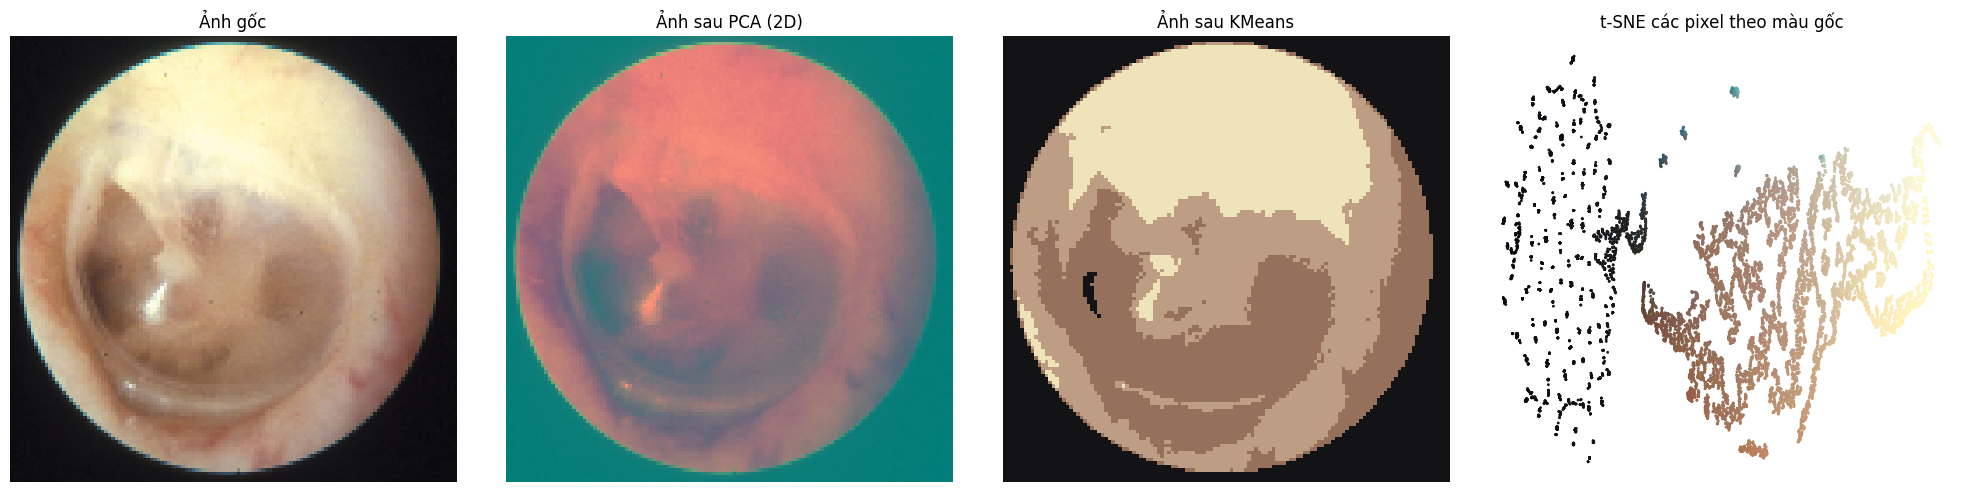

In [6]:
labels_map, colored_clusters = cluster_and_visualize_image(image_path, resize_dim=(128, 128), k=4)

c:\Users\han\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\manifold\_t_sne.py:996: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(


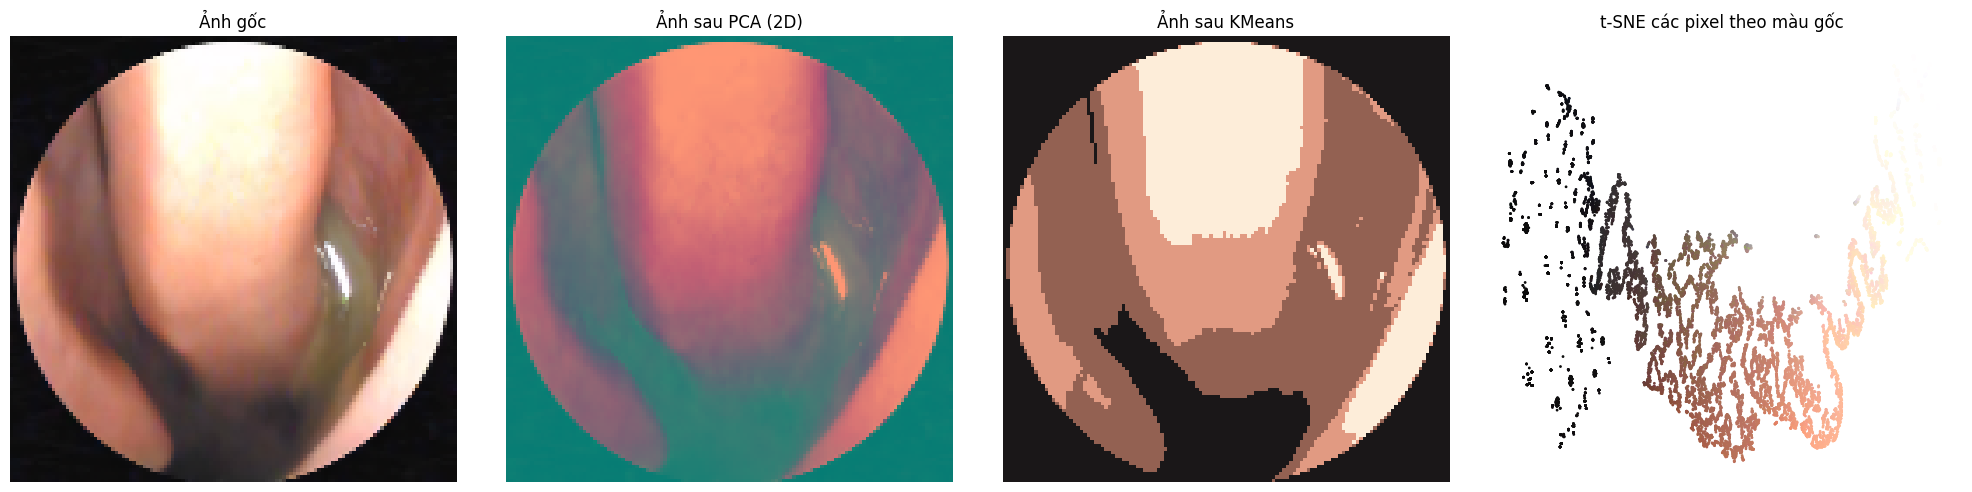

In [7]:
labels_map, colored_clusters = cluster_and_visualize_image(f'{image_folder}/16048305_190112085441890217_1557_1_Image3.png', resize_dim=(128, 128), k=4)